In [3]:
!pip install transformers torch
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification,AdamW
from torch.nn.functional import softmax


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00


In [4]:
df = pd.read_csv('/CombinedForums.csv')

In [5]:
import numpy as np

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment" # This BERT model is trained for sentiment analysis.
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [8]:
def predict_sentiments(texts, batch_size):
    sentiments = []
    model.to(device)  # Ensure model is on the correct device

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=1)
        sentiments.extend(preds.cpu().numpy())
    return sentiments

In [9]:
df['Comment'] = df['Comment'].astype(str)
batch_size = 32
df['sentiment'] = predict_sentiments(df['Comment'].tolist(), batch_size)

In [12]:
df.to_csv('dataset_with_sentiments.csv', index=False)

In [13]:
df

,Name,Comment,Date,Model,sentiment
0,Mazda 3s,After months of releasing preview images and s...,"August 29, 2022",Maserati Grecale,3
1,Darepoole,It looks like the Macan with a little bit of I...,"March 22, 2022",Maserati Grecale,2
2,JackStraw79,Nice hot hatch!,"March 22, 2022",Maserati Grecale,4
3,CostcoPizza,"Looks like a car you'd find in GTA V DLC, whic...","March 22, 2022",Maserati Grecale,3
4,Venom21,Terrible gloss black: CheckTerrible touchscree...,"March 22, 2022",Maserati Grecale,0
...,...,...,...,...,...
49370,Wing Commander,I suppose we should be grateful that at least ...,"October 02, 2021",Porsche Macan,4
49371,sd1985,Our first macan was a base on 21s with no Pasm...,"October 02, 2021",Porsche Macan,2
49372,BanZ,"For gen3, on the uk configurator PASM is not c...","October 02, 2021",Porsche Macan,3
49373,Col Lamb,Well that is another reason for avoiding the 2...,"October 02, 2021",Porsche Macan,0


In [14]:
df_with_sentiments = df.copy()

In [15]:
df_with_sentiments.to_csv('dataset_with_sentiments.csv', index=False)

In [16]:
# List of car models to filter by
car_models = ['Maserati Grecale', 'Alfa Romeo Stelvio', 'BMW X3', 'Audi Q5', 'Porsche Macan']

# Filter dataset by the car models
filtered_df = df_with_sentiments[df_with_sentiments['Model'].isin(car_models)]

# Group by 'Car Model' and 'sentiment' and count
grouped = filtered_df.groupby(['Model', 'sentiment']).size().reset_index(name='Count')

print(grouped)


                 Model  sentiment  Count
0   Alfa Romeo Stelvio          0   1597
1   Alfa Romeo Stelvio          1   1550
2   Alfa Romeo Stelvio          2   2551
3   Alfa Romeo Stelvio          3   1433
4   Alfa Romeo Stelvio          4   1326
5              Audi Q5          0   2199
6              Audi Q5          1   1785
7              Audi Q5          2   2743
8              Audi Q5          3   1645
9              Audi Q5          4   1626
10              BMW X3          0   2420
11              BMW X3          1   2251
12              BMW X3          2   3086
13              BMW X3          3   2147
14              BMW X3          4   2129
15    Maserati Grecale          0    188
16    Maserati Grecale          1    185
17    Maserati Grecale          2    216
18    Maserati Grecale          3    150
19    Maserati Grecale          4    148
20       Porsche Macan          0   3341
21       Porsche Macan          1   3335
22       Porsche Macan          2   5122
23       Porsche

In [ ]:
from torch.utils.data import Dataset

In [ ]:
# Constants
batch_size = 16
max_sequence_length = 256
epochs = 3
learning_rate = 2e-5

In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
# Dataset definition with adjustments
class SentimentDataset(Dataset):
    def __init__(self, tokenizer, comments, labels, max_len):
        self.tokenizer = tokenizer
        self.comments = comments
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# First, split the original df_with_sentiments into train and test
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(df_with_sentiments, test_size=0.3, random_state=42)

In [ ]:
train_data = SentimentDataset(tokenizer, train_df['Comment'].tolist(), train_df['sentiment'].tolist(), max_sequence_length)
test_data = SentimentDataset(tokenizer, test_df['Comment'].tolist(), test_df['sentiment'].tolist(), max_sequence_length)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
# Define the training function
def train_epoch(model, data_loader, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Define the evaluation function
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Train the model
n_epochs = 3
for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, len(train_df))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = eval_model(model, test_loader, device, len(test_df))
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()

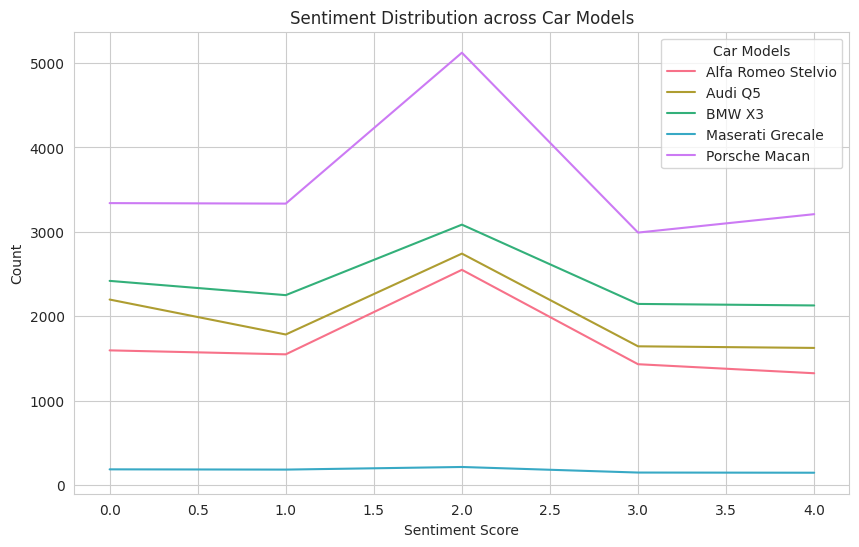

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("husl", len(car_models))

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='sentiment', y='Count', hue='Model', palette=palette)

# Set the title and labels
plt.title('Sentiment Distribution across Car Models')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend(title='Car Models')

plt.show()


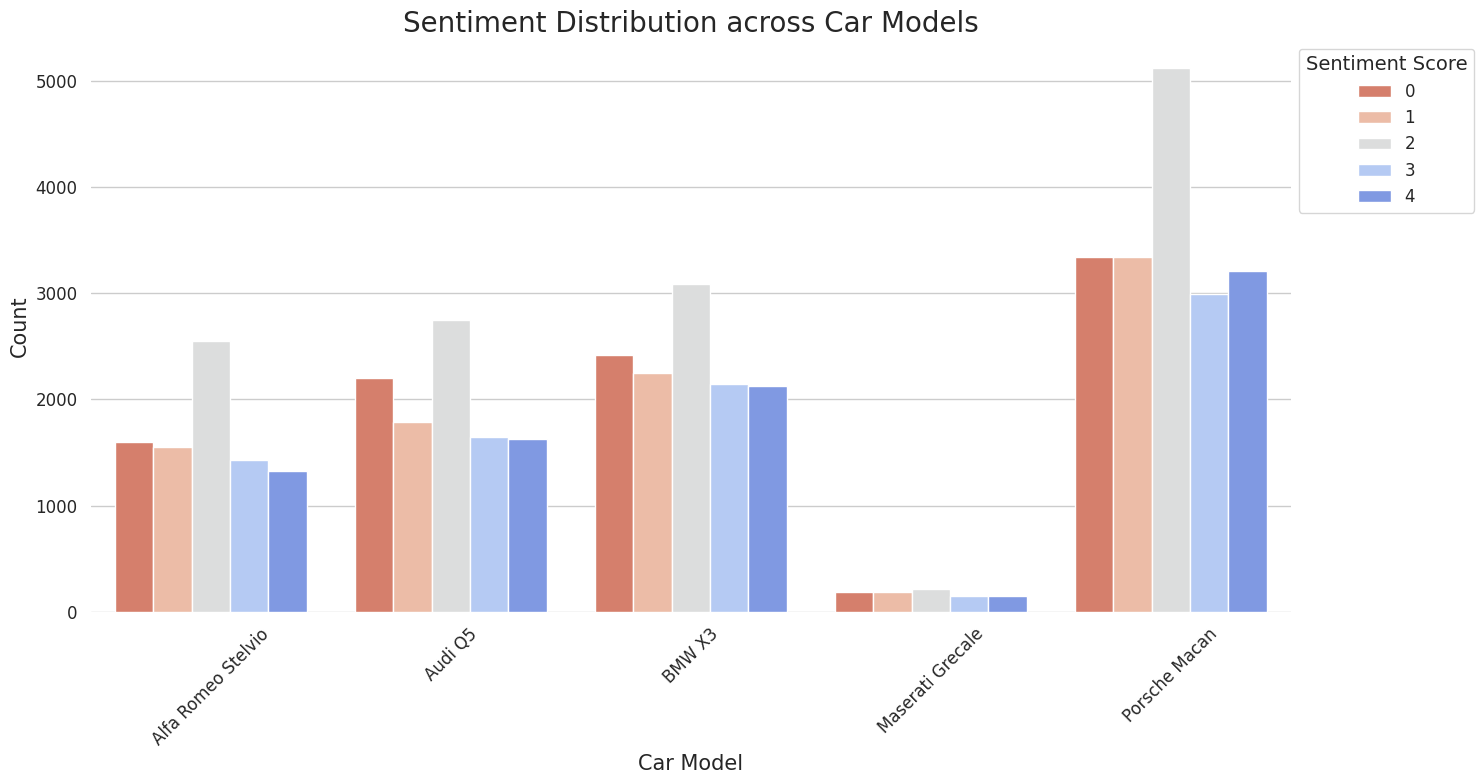

In [18]:
# Set theme and style
sns.set_theme(style="whitegrid")

# Set up a larger figure
plt.figure(figsize=(15, 8))

# Create a palette to visually differentiate sentiments
palette = sns.color_palette("coolwarm_r", 5)

# Grouped bar chart
chart = sns.barplot(data=grouped, x='Model', y='Count', hue='sentiment', palette=palette)

# Set the title and labels
plt.title('Sentiment Distribution across Car Models', fontsize=20)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Car Model', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment Score', title_fontsize='14', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

# Remove the borders for a cleaner look
sns.despine(left=True, bottom=True)

# Display the plot
plt.tight_layout()
plt.show()


<ipython-input-19-24fe04630ff5>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped['Percentage'] = grouped.groupby('Model')['Count'].apply(lambda x: x / x.sum() * 100)


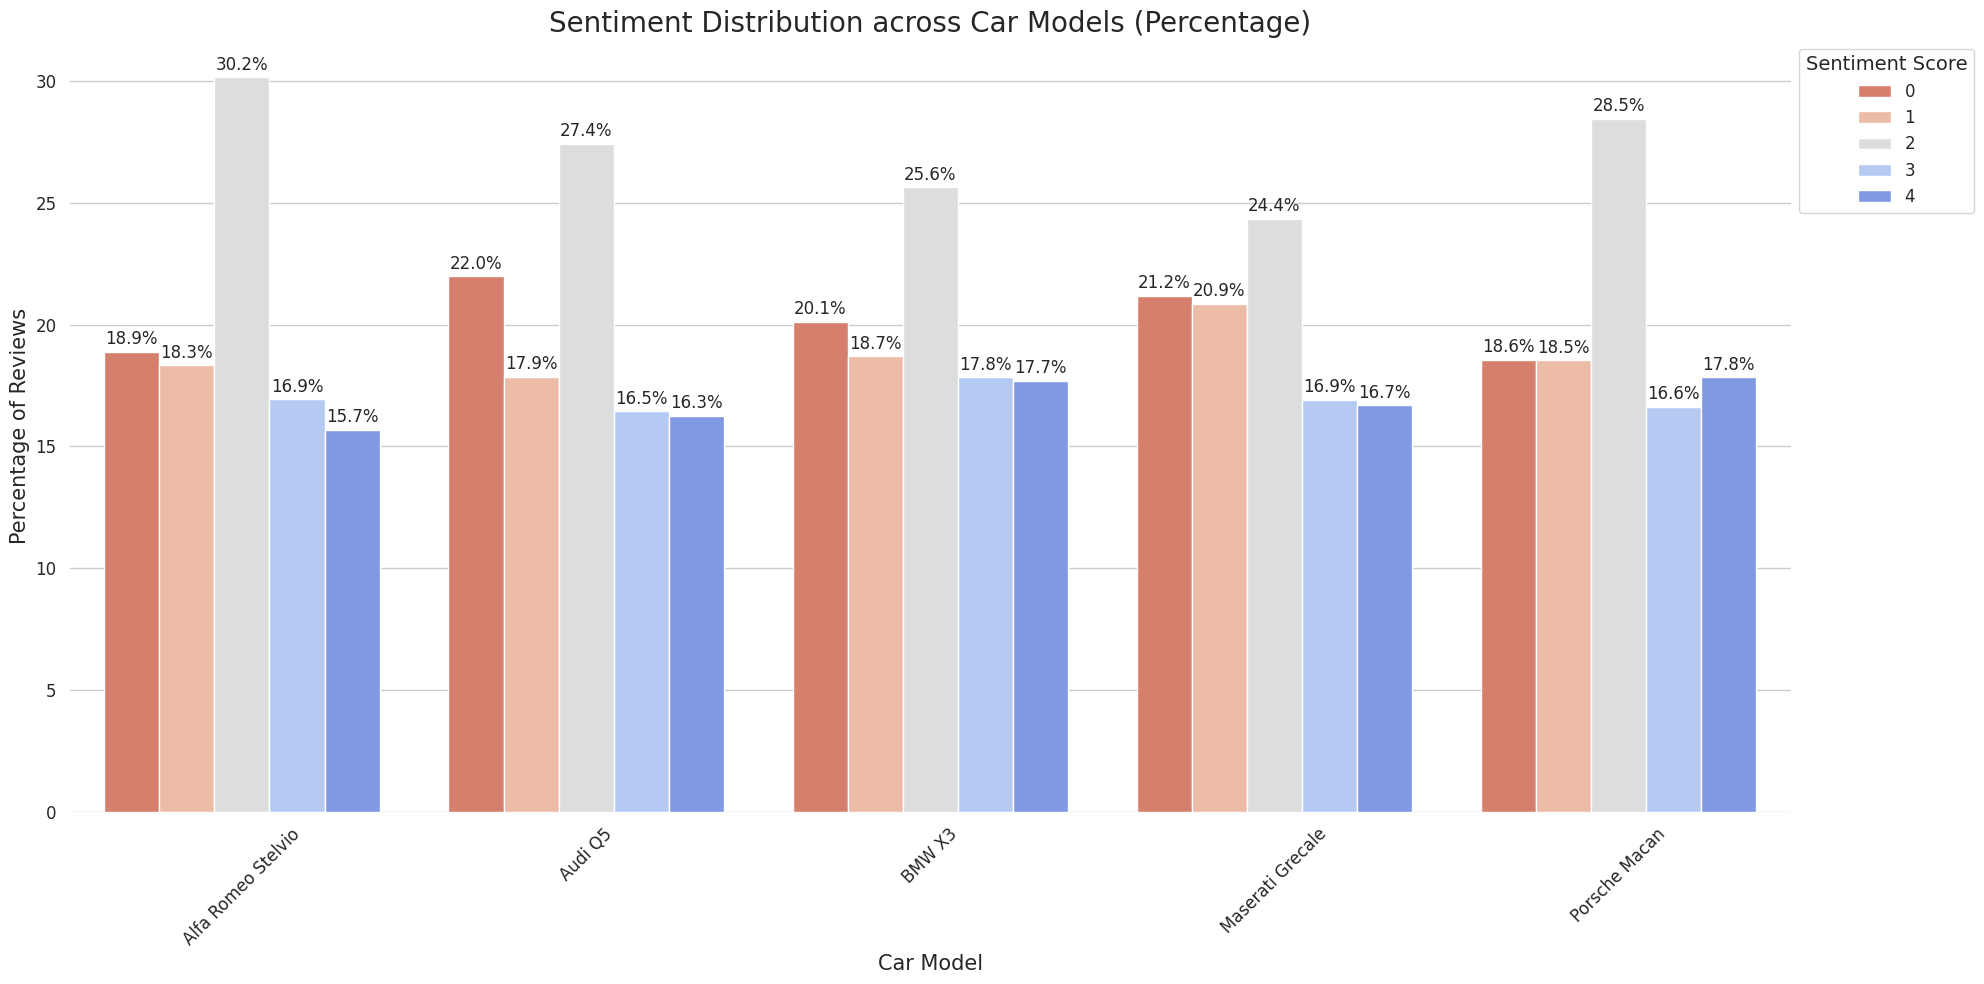

In [19]:
# Compute percentage for each sentiment score within each car model
grouped['Percentage'] = grouped.groupby('Model')['Count'].apply(lambda x: x / x.sum() * 100)

import seaborn as sns
import matplotlib.pyplot as plt

# Set theme and style
sns.set_theme(style="whitegrid")

# Set up a larger figure
plt.figure(figsize=(20, 10))

# Create a palette to visually differentiate sentiments
palette = sns.color_palette("coolwarm_r", 5)

# Grouped bar chart
chart = sns.barplot(data=grouped, x='Model', y='Percentage', hue='sentiment', palette=palette)

# Annotating each bar with the respective percentage
for p in chart.patches:
    chart.annotate(f'{p.get_height():.1f}%',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

# Set the title and labels
plt.title('Sentiment Distribution across Car Models (Percentage)', fontsize=20)
plt.ylabel('Percentage of Reviews', fontsize=15)
plt.xlabel('Car Model', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment Score', title_fontsize='14', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

# Remove the borders for a cleaner look
sns.despine(left=True, bottom=True)

# Display the plot
plt.tight_layout()
plt.show()


<ipython-input-20-4927bc701056>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped['Percentage'] = grouped.groupby('Model')['Count'].apply(lambda x: x / x.sum() * 100)


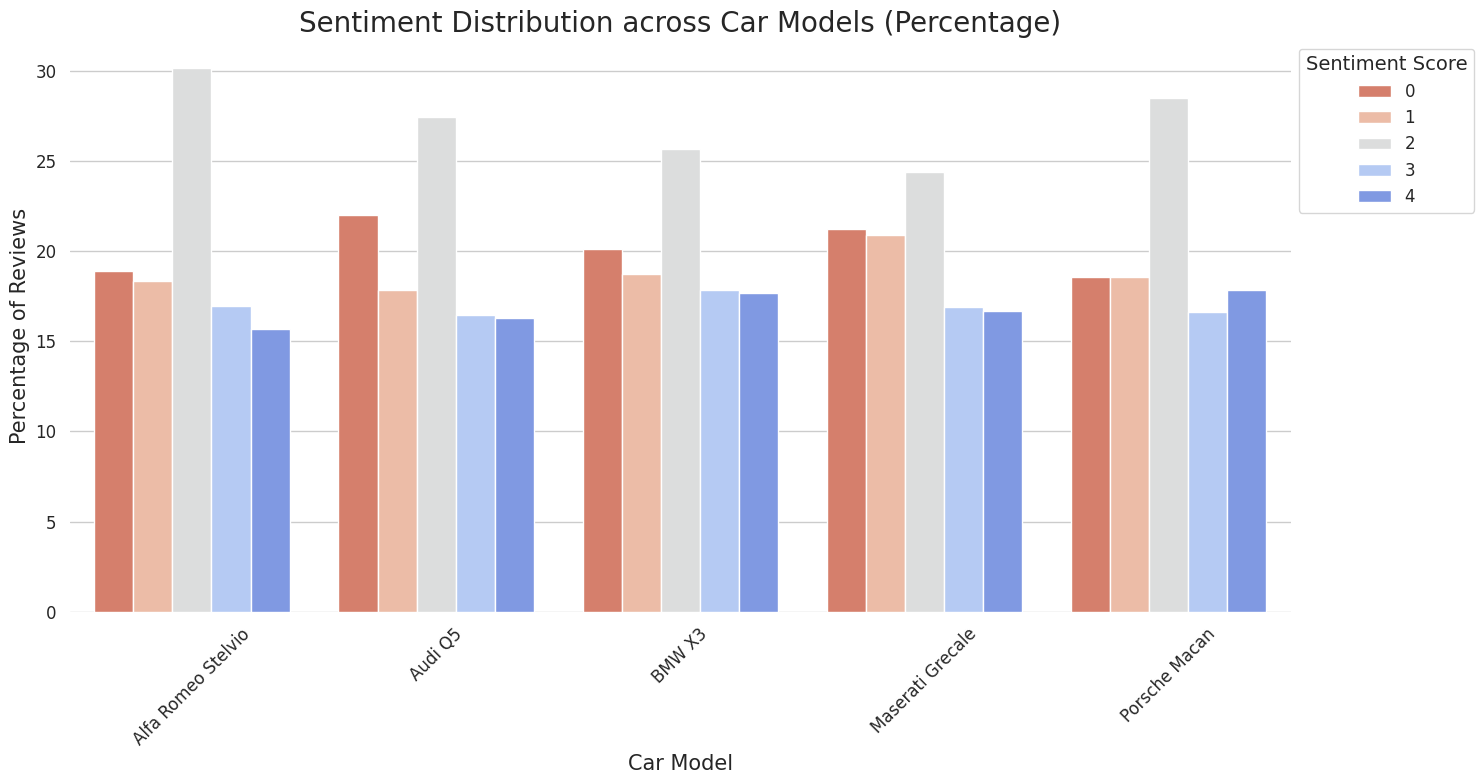

In [20]:
# Compute percentage for each sentiment score within each car model
grouped['Percentage'] = grouped.groupby('Model')['Count'].apply(lambda x: x / x.sum() * 100)

import seaborn as sns
import matplotlib.pyplot as plt

# Set theme and style
sns.set_theme(style="whitegrid")

# Set up a larger figure
plt.figure(figsize=(15, 8))

# Create a palette to visually differentiate sentiments
palette = sns.color_palette("coolwarm_r", 5)

# Grouped bar chart
chart = sns.barplot(data=grouped, x='Model', y='Percentage', hue='sentiment', palette=palette)

# Set the title and labels
plt.title('Sentiment Distribution across Car Models (Percentage)', fontsize=20)
plt.ylabel('Percentage of Reviews', fontsize=15)
plt.xlabel('Car Model', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment Score', title_fontsize='14', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

# Remove the borders for a cleaner look
sns.despine(left=True, bottom=True)

# Display the plot
plt.tight_layout()
plt.show()

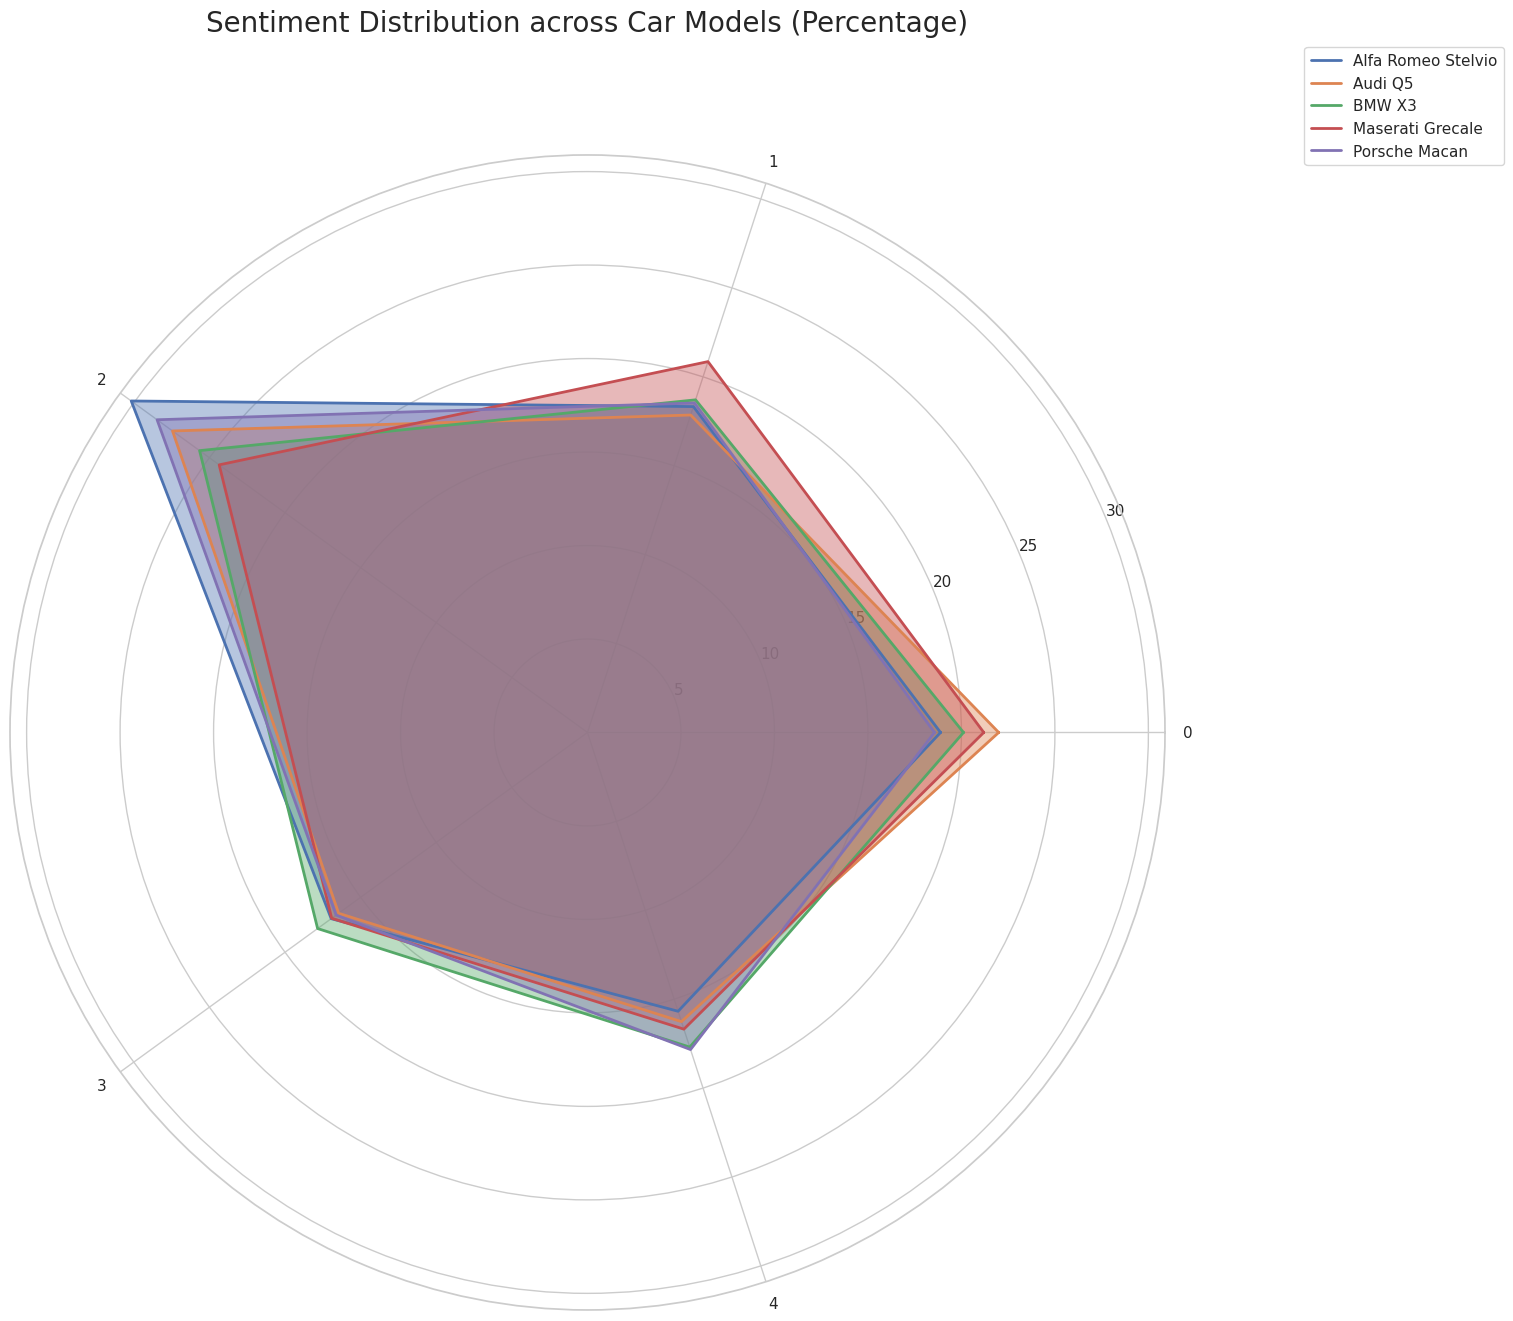

In [21]:
import numpy as np

# Number of variables (sentiments)
categories = grouped['sentiment'].unique()
N = len(categories)

# Set data
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(15, 15))
ax = plt.subplot(111, polar=True)

# Draw one axe per sentiment score with labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Plot data and fill with color for each car model
for i, model in enumerate(grouped['Model'].unique()):
    values = grouped[grouped['Model'] == model]['Percentage'].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.4)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Sentiment Distribution across Car Models (Percentage)', y=1.1, fontsize=20)
plt.show()


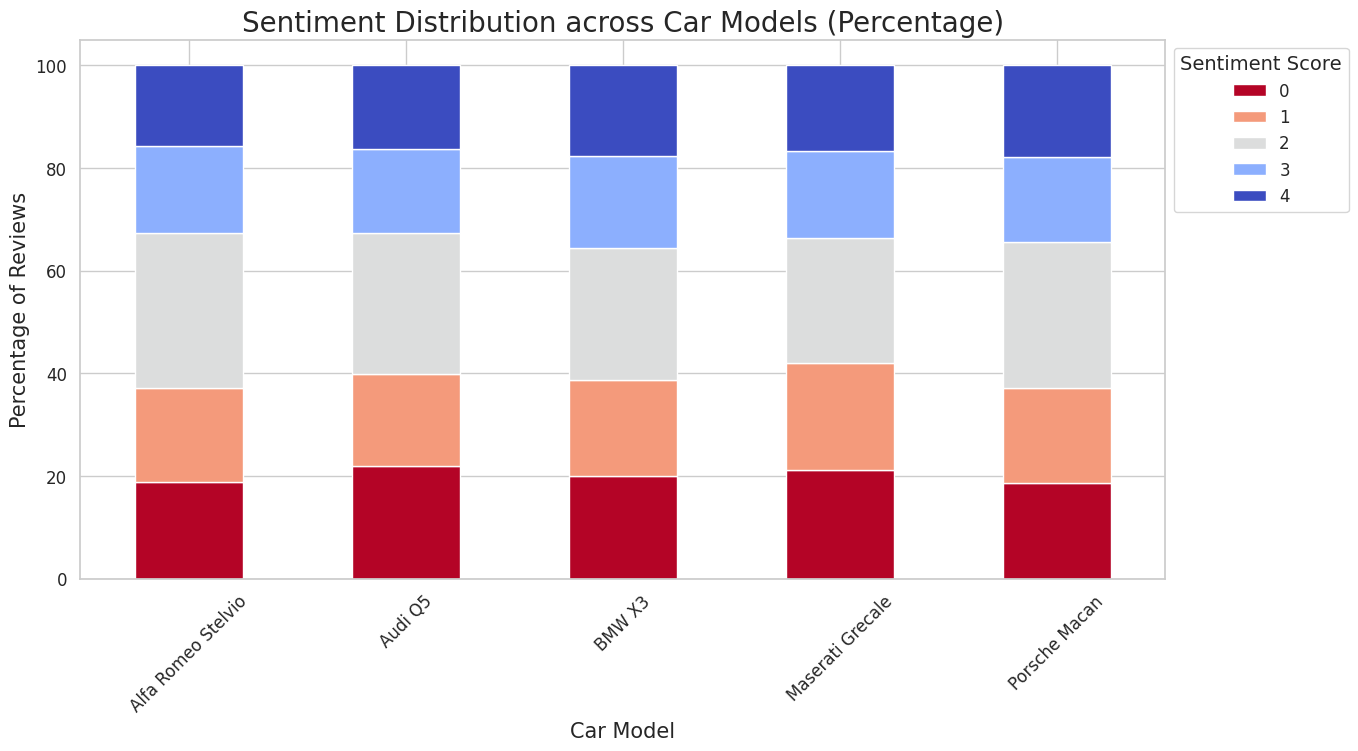

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Pivot the data for stacked bar chart
pivot_df = grouped.pivot(index='Model', columns='sentiment', values='Percentage')

# Plot
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14,7), colormap="coolwarm_r")
plt.title('Sentiment Distribution across Car Models (Percentage)', fontsize=20)
plt.ylabel('Percentage of Reviews', fontsize=15)
plt.xlabel('Car Model', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment Score', title_fontsize='14', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


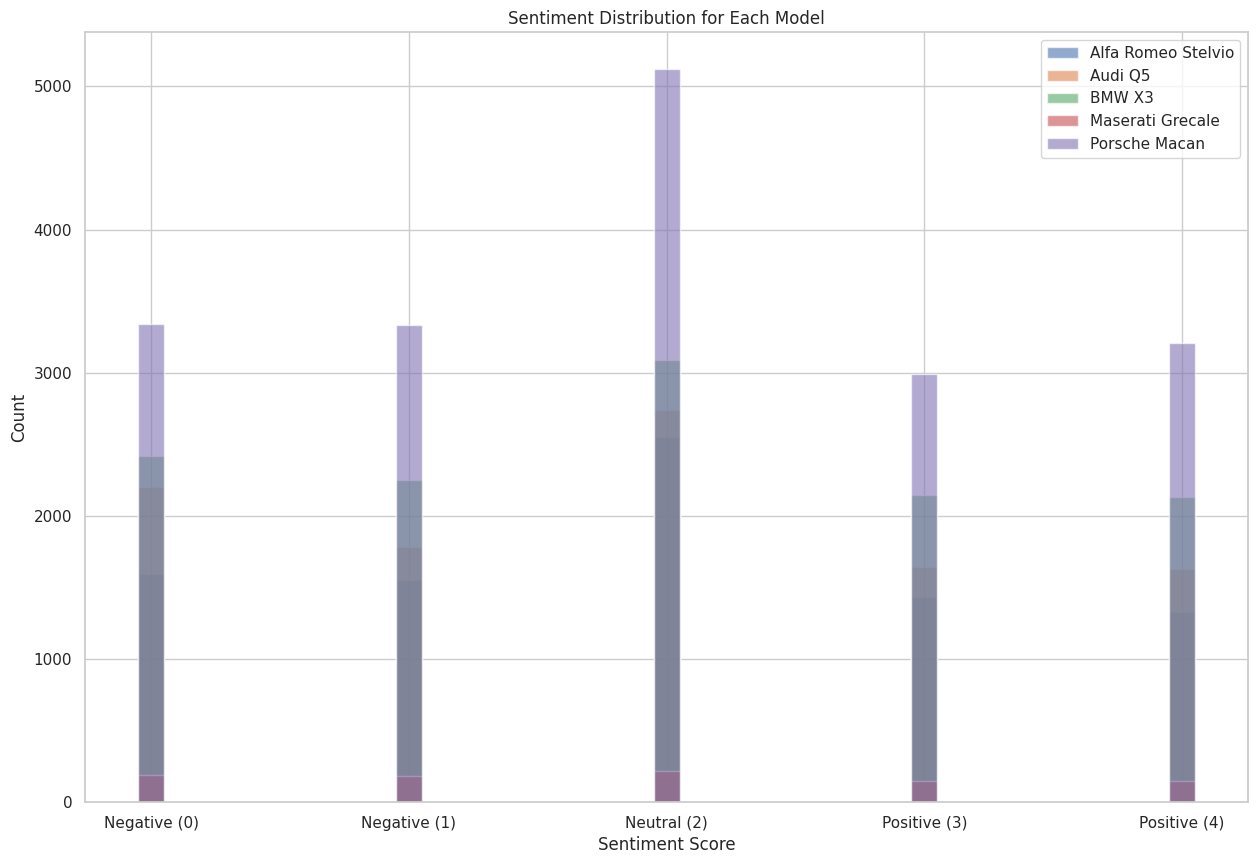

In [23]:
import matplotlib.pyplot as plt

# Convert the extracted sentiment results into a DataFrame
sentiment_data = {
    "Model": ["Alfa Romeo Stelvio", "Alfa Romeo Stelvio", "Alfa Romeo Stelvio", "Alfa Romeo Stelvio", "Alfa Romeo Stelvio",
              "Audi Q5", "Audi Q5", "Audi Q5", "Audi Q5", "Audi Q5",
              "BMW X3", "BMW X3", "BMW X3", "BMW X3", "BMW X3",
              "Maserati Grecale", "Maserati Grecale", "Maserati Grecale", "Maserati Grecale", "Maserati Grecale",
              "Porsche Macan", "Porsche Macan", "Porsche Macan", "Porsche Macan", "Porsche Macan"],
    "Sentiment Score": [0, 1, 2, 3, 4]*5,
    "Count": [1597, 1550, 2551, 1433, 1326,
              2199, 1785, 2743, 1645, 1626,
              2420, 2251, 3086, 2147, 2129,
              188, 185, 216, 150, 148,
              3341, 3335, 5122, 2992, 3210]
}

sentiment_df = pd.DataFrame(sentiment_data)

# Plotting the sentiment distribution
plt.figure(figsize=(15, 10))
for model in sentiment_df['Model'].unique():
    subset = sentiment_df[sentiment_df['Model'] == model]
    plt.bar(subset['Sentiment Score'], subset['Count'], label=model, alpha=0.6, width=0.1)

plt.title("Sentiment Distribution for Each Model")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["Negative (0)", "Negative (1)", "Neutral (2)", "Positive (3)", "Positive (4)"])
plt.legend()
plt.show()


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract the top keywords for each car model using TF-IDF
def extract_top_keywords(model_name, n_keywords=10):
    comments = df[df['Model'] == model_name]['Comment'].dropna()

    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_df=0.85, stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(comments)

    # Get feature names and sort them based on importance
    feature_names = vectorizer.get_feature_names_out()
    sorted_items = sorted(list(zip(feature_names, sum(tfidf_matrix.toarray()))), key=lambda x: x[1], reverse=True)

    # Get the top keywords
    keywords = [item[0] for item in sorted_items[:n_keywords]]
    return keywords

top_keywords = {}
for model_name in df['Model'].unique():
    top_keywords[model_name] = extract_top_keywords(model_name)

top_keywords


{'Maserati Grecale': ['car',
  'grecale',
  'maserati',
  'like',
  'just',
  'dealer',
  'new',
  'good',
  'modena',
  'issues'],
 'Alfa Romeo Stelvio': ['stelvio',
  'car',
  'just',
  'alfa',
  'like',
  'giulia',
  'think',
  've',
  'new',
  'good'],
 'BMW X3': ['x3',
  'car',
  'bmw',
  'just',
  'thanks',
  'like',
  'm40i',
  'dealer',
  'new',
  'don'],
 'Audi Q5': ['car',
  'audi',
  'just',
  'q5',
  'new',
  'sq5',
  'thanks',
  'good',
  'dealer',
  'like'],
 'Porsche Macan': ['car',
  'just',
  'nan',
  'macan',
  'porsche',
  'like',
  'good',
  'think',
  've',
  'gts']}

In [25]:
# Analyze the sentiment of comments containing the top keywords for each model
topic_sentiment_analysis = {}

for model, keywords in top_keywords.items():
    sentiment_distribution = {}
    for keyword in keywords:
        keyword_sentiments = df_with_sentiments[(df_with_sentiments['Model'] == model) & (df_with_sentiments['Comment'].str.contains(keyword, na=False, case=False))]['sentiment']
        sentiment_distribution[keyword] = keyword_sentiments.value_counts(normalize=True).to_dict()  # Getting percentages
    topic_sentiment_analysis[model] = sentiment_distribution

# Print the sentiment analysis results
print(topic_sentiment_analysis)


{'Maserati Grecale': {'car': {1: 0.25745257452574527, 0: 0.23035230352303523, 2: 0.20596205962059622, 3: 0.18699186991869918, 4: 0.11924119241192412}, 'grecale': {0: 0.24324324324324326, 3: 0.21621621621621623, 1: 0.21621621621621623, 2: 0.16891891891891891, 4: 0.1554054054054054}, 'maserati': {3: 0.2356687898089172, 0: 0.2356687898089172, 1: 0.21019108280254778, 2: 0.20382165605095542, 4: 0.11464968152866242}, 'like': {3: 0.267515923566879, 1: 0.2484076433121019, 2: 0.2356687898089172, 0: 0.17834394904458598, 4: 0.07006369426751592}, 'just': {1: 0.30201342281879195, 0: 0.2751677852348993, 2: 0.18120805369127516, 3: 0.16778523489932887, 4: 0.0738255033557047}, 'dealer': {0: 0.3375, 1: 0.21875, 2: 0.18125, 3: 0.15625, 4: 0.10625}, 'new': {3: 0.23741007194244604, 1: 0.2302158273381295, 4: 0.19424460431654678, 2: 0.17985611510791366, 0: 0.15827338129496402}, 'good': {3: 0.2777777777777778, 1: 0.2222222222222222, 2: 0.2, 4: 0.15555555555555556, 0: 0.14444444444444443}, 'modena': {1: 0.2409

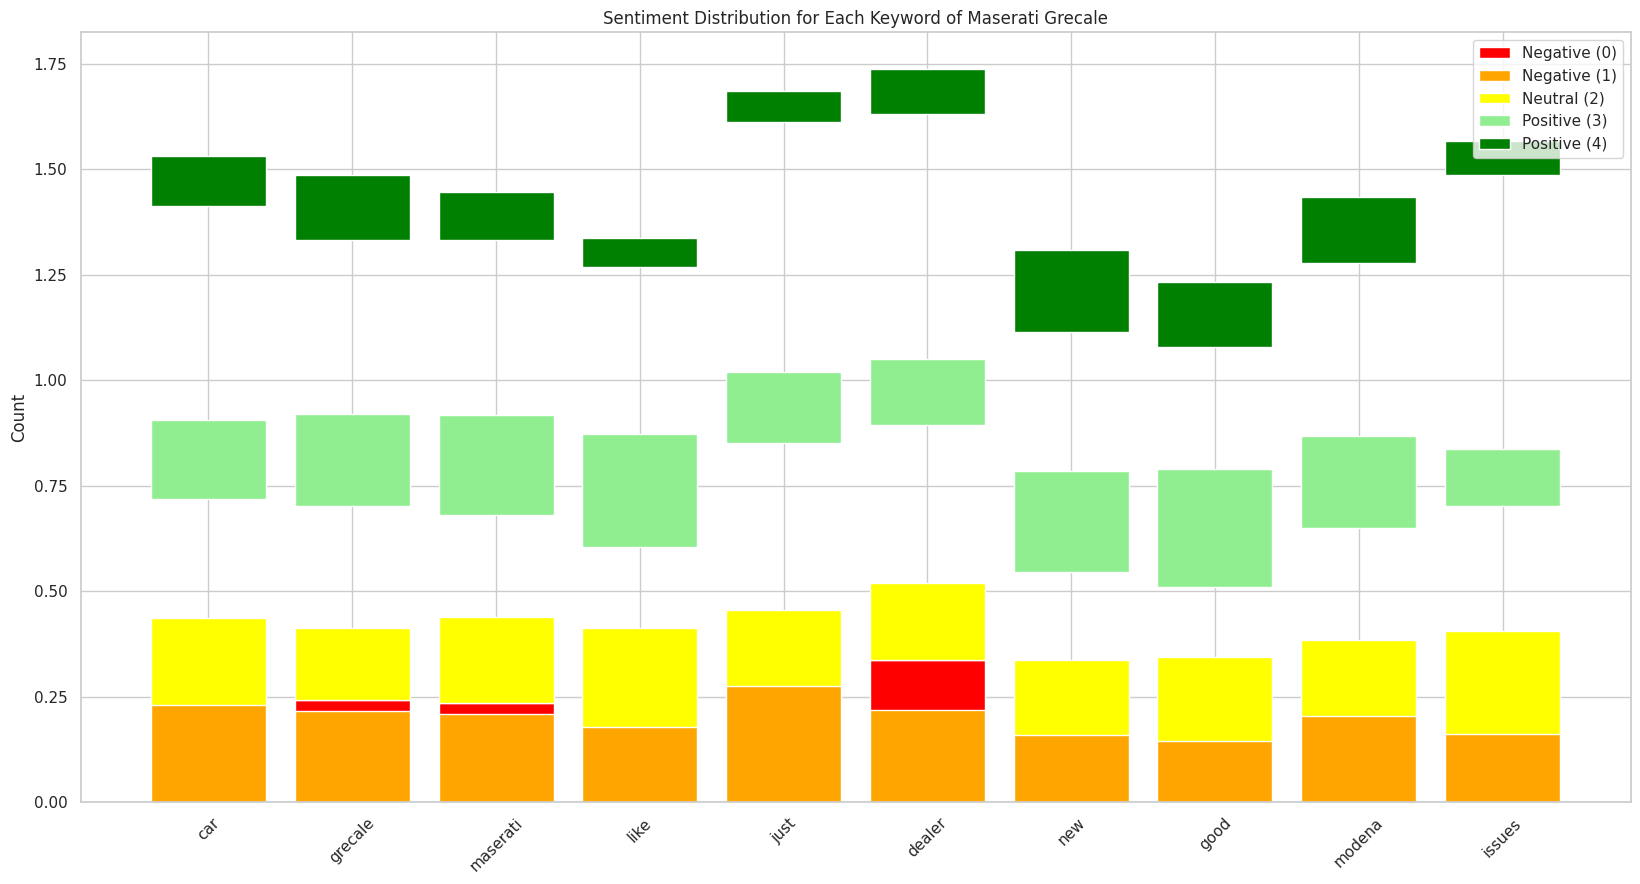

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Maserati Grecale
grecale_data = {
    'Maserati Grecale': {
        'car': {1: 0.25745257452574527, 0: 0.23035230352303523, 2: 0.20596205962059622, 3: 0.18699186991869918, 4: 0.11924119241192412},
        'grecale': {0: 0.24324324324324326, 3: 0.21621621621621623, 1: 0.21621621621621623, 2: 0.16891891891891891, 4: 0.1554054054054054},
        'maserati': {3: 0.2356687898089172, 0: 0.2356687898089172, 1: 0.21019108280254778, 2: 0.20382165605095542, 4: 0.11464968152866242},
        'like': {3: 0.267515923566879, 1: 0.2484076433121019, 2: 0.2356687898089172, 0: 0.17834394904458598, 4: 0.07006369426751592},
        'just': {1: 0.30201342281879195, 0: 0.2751677852348993, 2: 0.18120805369127516, 3: 0.16778523489932887, 4: 0.0738255033557047},
        'dealer': {0: 0.3375, 1: 0.21875, 2: 0.18125, 3: 0.15625, 4: 0.10625},
        'new': {3: 0.23741007194244604, 1: 0.2302158273381295, 4: 0.19424460431654678, 2: 0.17985611510791366, 0: 0.15827338129496402},
        'good': {3: 0.2777777777777778, 1: 0.2222222222222222, 2: 0.2, 4: 0.15555555555555556, 0: 0.14444444444444443},
        'modena': {1: 0.24096385542168675, 3: 0.21686746987951808, 0: 0.20481927710843373, 2: 0.18072289156626506, 4: 0.1566265060240964},
        'issues': {1: 0.3783783783783784, 2: 0.24324324324324326, 0: 0.16216216216216217, 3: 0.13513513513513514, 4: 0.08108108108108109}
    }
}

plt.figure(figsize=(20, 10))

# For each keyword, create a stacked bar
for idx, (keyword, sentiment_distribution) in enumerate(grecale_data['Maserati Grecale'].items()):
    sentiments = [0, 1, 2, 3, 4]
    counts = [sentiment_distribution[sent] for sent in sentiments]
    if idx == 0:
        bottom_counts = np.zeros(len(sentiments))
    plt.bar(idx, counts[0], label='Negative (0)' if idx == 0 else "", color='red')
    plt.bar(idx, counts[1], bottom=bottom_counts[0], label='Negative (1)' if idx == 0 else "", color='orange')
    bottom_counts[1] = counts[0]
    plt.bar(idx, counts[2], bottom=bottom_counts[0]+bottom_counts[1], label='Neutral (2)' if idx == 0 else "", color='yellow')
    bottom_counts[2] = counts[0] + counts[1]
    plt.bar(idx, counts[3], bottom=bottom_counts[0]+bottom_counts[1]+bottom_counts[2], label='Positive (3)' if idx == 0 else "", color='lightgreen')
    bottom_counts[3] = counts[0] + counts[1] + counts[2]
    plt.bar(idx, counts[4], bottom=bottom_counts[0]+bottom_counts[1]+bottom_counts[2]+bottom_counts[3], label='Positive (4)' if idx == 0 else "", color='green')

plt.title("Sentiment Distribution for Each Keyword of Maserati Grecale")
plt.xticks(range(len(grecale_data['Maserati Grecale'])), grecale_data['Maserati Grecale'].keys(), rotation=45)
plt.ylabel("Count")
plt.legend()
plt.show()


In [27]:
# Extracting a sample of negative comments for Maserati Grecale
negative_comments_grecale = df[(df['Model'] == 'Maserati Grecale') & (df['sentiment'] <= 1)]['Comment'].tolist()

negative_comments_grecale

['Terrible gloss black: CheckTerrible touchscreen to control climate: CheckCar interiors circa 2020s',
 'hahaha I thought it looked familiar they are almost identical',
 "LOL don't be shook by the prima donna would-be know-it-all b:tches around here who will absolutely complain about anything and everything.",
 "I knew it had a doppleganger!This thing seems so insanely redundant.... best of luck to Maserati, can't see who's gonna jump on this over the other dozen similar offerings but w/e",
 "So what, are they supposed to just stop making cars? Every new vehicle is a chance to improve their reputation. The launch of the new Grand Cherokee still has me weary of pre-Stellantis projects but I guess we'll see what happens. You'd think they'd put their A team on this car given Maserati is Stellantis' only global luxury brand.",
 'No physical HVAC controls, no care.',
 "I dont think anyone is looking to end the livelihoods of everyone dependent on Maserati's successBut theyve spent decades g

In [28]:
# Extracting negative comments for Alfa Romeo Stelvio
negative_comments_stelvio = df[(df['Model'] == 'Alfa Romeo Stelvio') & (df['sentiment'] <= 1)]['Comment'].tolist()
negative_comments_stelvio

['The official launch is next Saturday but there are cars in (some, probably all) dealerships & orders have been open since 1st Aug.',
 "Ahh right, I'll cut Alfa a bit of slack for now then. But it wouldn't have hurt to give the press RHD versions for UK road testing I think. It's really not nice driving a LHD vehicle in the UK, and Alfa don't want to give journalists any excuse to get the car marked down.I've seen a couple of dealers post online this evening saying they now have their RHD cars in stock, and unlike with the Giulia it looks like Alfa has supplied more eye-catching white & Misano Blue models. Now all they need to do is a launch advert this week. Trouble is they don't have enough dealers to get too many people through the doors at once :idea:",
 "I thought I'd not seen Misano Blue on the configurator. Having checked, it's not on there, but one of the dealers has a RHD one in Misano. And there was a pretty nice dark green in the brochure but that's not on the configurator 

In [29]:
negative_comments_Q5 = df[(df['Model'] == 'Audi Q5') & (df['sentiment'] <= 1)]['Comment'].tolist()
negative_comments_Q5

['Not rules, just some thoughts for your consideration. Please be nice to other forum members. Unfortunately every web forum attracts spammers and trolls. Try to avoid discussions with them and report it to admin. To post photos: please post your photo to one of the free web hosting sites, copy the URL, select the Image icon above your post text box, paste the URL and return. Please avoid posting large photo files as these take up bandwidth. Do you have any other useful tips for forum members?',
 'I knew it was too good to be true!',
 "The links to his images are to an external site. It is likely he turned them upside down himself in protest of being kicked (he's that kind of guy!).Sent fromAutoGuide.com Free App",
 'One thing I agree with Trump, we are rapidly becoming a third world country',
 'My dealer just told me to expect 6-8 weeks for delivery via Emden after the build week.',
 'I ordered mine on the 19th March and was given provisional week 16 build and estimated delivery 31st 

In [30]:
negative_comments_X3 = df[(df['Model'] == 'BMW X3') & (df['sentiment'] <= 1)]['Comment'].tolist()
negative_comments_X3

['nan',
 'Sorry should read"pdf\'',
 'When will orders be acceptedI\'ve done the "build you own" on the BMW website and my local dealer has taken a deposit, but they are being cagey about when US orders actually open. Where did you hear "March" 2020 ? Anyone else actually have factory confirmation that their build is in production?',
 'all electric range EPA estimates?Hi Jon,What is the all electric range rated at? Thanks.',
 "Confused by HP rating of PHEVSo I'm confused by why the 2.0L Turbo 4 engine in the X3 non-hybrid is rated at 248HP, but when placed in the hybrid alongside an electric motor, the same (?) engine is rated at only 181HP. What am I missing (other than a basic understanding of HP & Torque)?Also, has a combined gas+electric range for the 30e been published or rumored?",
 "That’s our setup on my wife’s 2020 X3 M40i. I have a 07 Z4 3.0si with summer performance staggered tires and aftermarket struts/coils. As to performance, unless you’re going to track the car, you pro

In [31]:
negative_comments_macan = df[(df['Model'] == 'Porsche Macan') & (df['sentiment'] <= 1)]['Comment'].tolist()
negative_comments_macan

['During a regular service at my local OPC (Tonbridge), I received a phone call saying everything was good, but the rear wiper needed replacing and could they do it for me.  Just before I said "yes", I asked "how much" and the answer was a staggering £68 - so I said "no" and picked up a Bosch one for just over ten quid.I am absolutely speechless - what do the rest of you think?',
 'Part of that £68 is £50 labour.',
 "Wow. That's ridiculous.",
 'After only 6 months? Are you one of those who we see on a sunny hot day with the rear wiper waving at us?',
 '1. It probably didn’t need replacing.2. Inclusive of hefty Porsche tax, to help to pay their army of staff and to recover the cost of their multi-million pound premises.  Not to mention coffee & pastries.',
 'or to cover the cost of financing unsold Taycans',
 'Consider yourselves lucky.Those of us with early Macan Gen 1 had a standard wiper that was dire, it squeaked and juddered badly, solution was to fit a replacement Bosch that we pa

MACAN

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
nltk.download('punkt')


# Load necessary resources
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocess the comments
def preprocess_comments(comments):
    processed_comments = []

    for comment in comments:
        # Tokenize and lower
        tokens = nltk.word_tokenize(comment.lower())

        # Remove stopwords and punctuation, and lemmatize
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token not in string.punctuation]

        processed_comments.append(' '.join(tokens))

    return processed_comments

# Preprocess the negative comments for Porsche Macan
processed_comments_macan = preprocess_comments(negative_comments_macan)

# Vectorize the comments
vectorizer_macan = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
data_vectorized_macan = vectorizer_macan.fit_transform(processed_comments_macan)

# Apply LDA
lda_model_macan = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model_macan.fit(data_vectorized_macan)

# Extract topics and representative words for each topic
macan_topics = {}
for idx, topic in enumerate(lda_model_macan.components_):
    macan_topics[f"Topic {idx+1}"] = [vectorizer_macan.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]]

macan_topics


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'Topic 1': ['porsche',
  'car',
  'nan',
  'year',
  'tyre',
  'insurance',
  'warranty',
  'use',
  'know',
  'pay'],
 'Topic 2': ['car',
  'porsche',
  'year',
  'battery',
  'opc',
  'time',
  'like',
  'macan',
  'think',
  'buy'],
 'Topic 3': ['car',
  'service',
  'year',
  'oil',
  'mile',
  'opc',
  'change',
  'warranty',
  'month',
  'gts'],
 'Topic 4': ['macan',
  'car',
  'wheel',
  'porsche',
  'like',
  'cost',
  'way',
  'black',
  'think',
  'time'],
 'Topic 5': ['car',
  'macan',
  'new',
  'opc',
  'porsche',
  'like',
  'day',
  'time',
  'week',
  'drive']}

Let's interpret these topics:

1. **Topic 1**:
   - **Main Theme**: Costs associated with ownership.
   - **Keywords**: Porsche, car, year, tyre, insurance, warranty, use, know, pay.
   - **Interpretation**: This topic seems to revolve around the expenses and costs associated with owning a Porsche. The mention of 'tyre', 'insurance', and 'warranty' suggests concerns or discussions about maintenance costs and insurance premiums.

2. **Topic 2**:
   - **Main Theme**: Considerations before buying.
   - **Keywords**: Car, Porsche, year, battery, opc, time, like, Macan, think, buy.
   - **Interpretation**: Potential buyers are discussing the factors they're considering before purchasing a Porsche Macan. The mention of 'battery' might suggest concerns about battery life or replacement.

3. **Topic 3**:
   - **Main Theme**: Maintenance and service.
   - **Keywords**: Car, service, year, oil, mile, opc, change, warranty, month, gts.
   - **Interpretation**: Owners are discussing regular maintenance activities, including oil changes and mileage-based services. They might be discussing the frequency of service, warranty terms, or specific issues they've faced.

4. **Topic 4**:
   - **Main Theme**: Aesthetics and customization.
   - **Keywords**: Macan, car, wheel, Porsche, like, cost, way, black, think, time.
   - **Interpretation**: This topic seems to focus on the look and feel of the Macan, with mentions of 'wheel' and 'black', suggesting discussions about customizations, color options, and possibly rim choices.

5. **Topic 5**:
   - **Main Theme**: New car experience.
   - **Keywords**: Car, Macan, new, opc, Porsche, like, day, time, week, drive.
   - **Interpretation**: Owners might be discussing their initial experiences with their new Macan. The mention of 'day', 'time', and 'week' suggests that these are recent purchases, and people are sharing their first impressions.

Based on the topics and their interpretations, some of the main critical aspects of the Porsche Macan compared to competitors might be:

1. **Costs of Ownership**: Concerns about insurance, warranty, and general expenses.
2. **Maintenance**: Discussions about regular service, potential issues, and warranty terms.
3. **Aesthetics & Customization**: Preferences or dislikes about the car's design, color options, and customization choices.
4. **Initial Experience with the Car**: Impressions from the first few days or weeks of owning the car.


In [35]:
# Filtering comments related to "Costs of Ownership"
cost_keywords_macan = ['insurance', 'warranty', 'tyre', 'pay']
cost_related_comments_macan = [comment for comment in negative_comments_macan if any(keyword in comment for keyword in cost_keywords)]

# Fetching a subset of these comments for examination
sample_cost_related_comments_macan = cost_related_comments_macan[:10]  # Taking the first 10 comments for examination
sample_cost_related_comments_macan

['1. It probably didn’t need replacing.2. Inclusive of hefty Porsche tax, to help to pay their army of staff and to recover the cost of their multi-million pound premises.  Not to mention coffee & pastries.',
 "The problem I've got with Porsche (and probably other manufacturers) is that the first indication you get that the battery is going down a bit is a flurry of spurious alarms. It's as though the electronics have a higher voltage threshold of failure than the engine because the thing was turning over beautifully.If that's the case, in this high tech world, why isn't the car warning of this BEFORE the gremlins start to show.And even better than that, why don't the cars monitoring systems learn the fact that the car is doing short journeys on a regular basis and allow charging from the alternator from the get-go, just like the old days.Or build in an option in the car's menu that allows the owner to input the expected driving profile so they don't have to worry about charging it up 

X3

In [46]:
# Preprocess the negative comments for Porsche Macan
processed_comments_X3 = preprocess_comments(negative_comments_X3)

# Vectorize the comments
vectorizer_X3 = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
data_vectorized_X3 = vectorizer_X3.fit_transform(processed_comments_X3)

# Apply LDA
lda_model_X3 = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model_X3.fit(data_vectorized_X3)

# Extract topics and representative words for each topic
X3_topics = {}
for idx, topic in enumerate(lda_model_X3.components_):
    X3_topics[f"Topic {idx+1}"] = [vectorizer_X3.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]]

X3_topics

{'Topic 1': ['bmw',
  'x3',
  'car',
  'dealer',
  'like',
  'new',
  'know',
  'issue',
  'said',
  '2019'],
 'Topic 2': ['car',
  'sent',
  'iphone',
  'using',
  'time',
  'app',
  'start',
  'like',
  'button',
  'turn'],
 'Topic 3': ['car',
  'tire',
  'mile',
  'time',
  'problem',
  'bmw',
  'said',
  'driving',
  'like',
  'run'],
 'Topic 4': ['bmw',
  'dealer',
  'x3',
  'car',
  'year',
  'price',
  'said',
  'deal',
  'msrp',
  'order'],
 'Topic 5': ['wheel',
  'x3',
  'tire',
  'seat',
  'steering',
  'm40i',
  'bmw',
  'sport',
  'like',
  'said']}

BMW X3:
Topics:

Dealership Experience: The prominence of terms like 'dealer', 'new', 'issue', and '2019' suggests that there may be concerns related to the dealership experience, perhaps in relation to specific model years or how dealers handle certain issues.

Infotainment and Tech: With terms like 'sent', 'iphone', 'app', 'start', 'button', and 'turn', this topic seems to be addressing the car's integration with smartphones, the functionality of the car's app, and perhaps issues related to starting the car or using certain features.

Tire and Mileage Issues: The terms 'tire', 'mile', 'problem', 'driving', and 'run' indicate issues related to the vehicle's tires and possibly concerns about mileage or how the car performs over long distances.

Pricing and Ordering: The prominence of terms like 'price', 'deal', 'msrp', and 'order' suggests concerns related to the cost of the X3, how dealers are pricing the car, and possibly issues or delays related to ordering the vehicle.

Driving Experience: With terms like 'wheel', 'tire', 'seat', 'steering', 'm40i', and 'sport', this topic points to the overall driving experience, which may include the feel of the steering, the comfort of the seats, and the performance of specific models like the m40i.

Q5

In [48]:
# Preprocess the negative comments for Porsche Macan
processed_comments_Q5 = preprocess_comments(negative_comments_Q5)

# Vectorize the comments
vectorizer_Q5 = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
data_vectorized_Q5 = vectorizer_Q5.fit_transform(processed_comments_Q5)

# Apply LDA
lda_model_Q5 = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model_Q5.fit(data_vectorized_Q5)

# Extract topics and representative words for each topic
Q5_topics = {}
for idx, topic in enumerate(lda_model_Q5.components_):
    Q5_topics[f"Topic {idx+1}"] = [vectorizer_Q5.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]]

Q5_topics

{'Topic 1': ['car',
  'new',
  'sq5',
  'like',
  'know',
  'q5',
  'diesel',
  'petrol',
  'really',
  'time'],
 'Topic 2': ['car',
  'mile',
  'year',
  'using',
  'www',
  'tapatalk',
  'sent',
  'iphone',
  'service',
  'http'],
 'Topic 3': ['car',
  'audi',
  'dealer',
  'q5',
  'new',
  'week',
  'order',
  'uk',
  'said',
  'sq5'],
 'Topic 4': ['tyre',
  'audi',
  'wheel',
  'car',
  'new',
  'q5',
  'need',
  'winter',
  'service',
  'issue'],
 'Topic 5': ['like',
  'q5',
  'look',
  'car',
  'black',
  'colour',
  'light',
  've',
  'new',
  'drive']}

Audi Q5:
Topics:

Vehicle Types and Fuel: The prominence of terms like 'new', 'sq5', 'diesel', 'petrol', and 'really' suggests discussions surrounding the different types of Q5 models and their fuel types. People might be comparing the diesel vs. petrol versions and discussing what they really prefer in the newer models.

Maintenance and Tech Integration: Terms like 'mile', 'year', 'service', 'tapatalk', 'iphone', and 'http' point towards the car's maintenance over a period and its integration or user experience with certain apps or devices.

Dealership and Ordering Experience: This topic, highlighted by terms like 'audi', 'dealer', 'order', 'week', and 'uk', seems to revolve around the experience of ordering a Q5, the waiting period, and interactions with the dealerships, especially in the UK context.

Tires, Wheels, and Maintenance: The prominence of 'tyre', 'wheel', 'need', 'winter', and 'issue' indicates concerns related to the vehicle's tires, possibly the need for winter tires, and other related maintenance issues.

Vehicle Aesthetics and Driving Experience: Terms like 'look', 'black', 'colour', 'light', and 'drive' suggest discussions centered on the Q5's appearance, color preferences, lighting, and the overall driving experience.

Stelvio

In [49]:
# Preprocess the negative comments for Porsche Macan
processed_comments_stelvio = preprocess_comments(negative_comments_stelvio)

# Vectorize the comments
vectorizer_stelvio = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
data_vectorized_stelvio = vectorizer_stelvio.fit_transform(processed_comments_stelvio)

# Apply LDA
lda_model_stelvio = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model_stelvio.fit(data_vectorized_stelvio)

# Extract topics and representative words for each topic
stelvio_topics = {}
for idx, topic in enumerate(lda_model_stelvio.components_):
    stelvio_topics[f"Topic {idx+1}"] = [vectorizer_stelvio.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]]

stelvio_topics

{'Topic 1': ['using',
  'fuel',
  'car',
  'tapatalk',
  'stelvio',
  'iphone',
  'www',
  'sent',
  'like',
  'uk'],
 'Topic 2': ['car',
  'stelvio',
  'year',
  'alfa',
  'like',
  'dealer',
  'new',
  'warranty',
  'week',
  'work'],
 'Topic 3': ['car',
  'stelvio',
  'wheel',
  'like',
  'tyre',
  'look',
  'red',
  'giulia',
  'blue',
  'road'],
 'Topic 4': ['battery',
  'car',
  'got',
  'time',
  'roof',
  'issue',
  'like',
  'start',
  'stelvio',
  'light'],
 'Topic 5': ['car',
  'alfa',
  'dealer',
  'service',
  'stelvio',
  'update',
  'year',
  'new',
  'time',
  'know']}

Alfa Romeo Stelvio:
Topics:

Fuel and Tech Integration: The terms 'fuel', 'using', 'tapatalk', 'iphone', and 'www' hint at discussions surrounding fuel efficiency or consumption and the vehicle's integration or user experience with specific apps or devices. The mention of 'uk' might indicate region-specific discussions or concerns.

Dealership, Warranty, and Maintenance: Words like 'year', 'dealer', 'warranty', 'week', and 'work' suggest discussions centered around the warranty period, interactions with dealerships, maintenance schedules, and potential issues that needed work or repair.

Vehicle Aesthetics and Tires: This topic seems to revolve around the Stelvio's appearance and tire-related concerns, as indicated by 'wheel', 'look', 'red', 'blue', and 'road'. There might also be comparisons or mentions of another Alfa Romeo model, the 'Giulia'.

Battery and Lighting Issues: Terms such as 'battery', 'roof', 'issue', 'start', and 'light' hint at potential concerns or problems related to the vehicle's battery, starting mechanism, roof (perhaps a sunroof or convertible feature), and lighting system.

Service and Updates: This topic, highlighted by 'alfa', 'dealer', 'service', 'update', and 'time', seems to be about the servicing experience of the Stelvio, updates (either software or hardware), and interactions with Alfa Romeo dealerships.

Grecale

In [50]:
# Preprocess the negative comments for Porsche Macan
processed_comments_grecale = preprocess_comments(negative_comments_grecale)

# Vectorize the comments
vectorizer_grecale = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
data_vectorized_grecale = vectorizer_grecale.fit_transform(processed_comments_grecale)

# Apply LDA
lda_model_grecale = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model_grecale.fit(data_vectorized_grecale)

# Extract topics and representative words for each topic
grecale_topics = {}
for idx, topic in enumerate(lda_model_grecale.components_):
    grecale_topics[f"Topic {idx+1}"] = [vectorizer_grecale.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]]

grecale_topics

{'Topic 1': ['car',
  'issue',
  'door',
  'like',
  'key',
  'dealer',
  'grecale',
  'update',
  'work',
  'day'],
 'Topic 2': ['car',
  'phone',
  'dealer',
  'sound',
  'option',
  'charger',
  'charging',
  'order',
  'working',
  'grecale'],
 'Topic 3': ['car',
  'dealer',
  'maserati',
  'told',
  'issue',
  'said',
  'care',
  'position',
  'driving',
  'mode'],
 'Topic 4': ['car',
  'vehicle',
  'issue',
  'time',
  'battery',
  'new',
  'grecale',
  'make',
  'said',
  'right'],
 'Topic 5': ['car',
  'issue',
  'maserati',
  'grecale',
  'modena',
  'like',
  'seat',
  'month',
  'brake',
  'time']}

Vehicle Access & Dealership Interactions: This topic, marked by terms such as 'car', 'issue', 'door', 'key', 'dealer', 'update', and 'work', seems to indicate concerns related to accessing the car (perhaps issues with the key or the door) and interactions or resolutions offered by the dealerships. 'Update' might hint at software or system updates.

Tech Integration and Charging: With words like 'phone', 'charger', 'charging', 'sound', and 'option', this topic suggests discussions about the vehicle's integration with phones, its sound system, and potentially about its charging system if it's a hybrid or electric variant.

Dealership Communication & Driving Mode: This topic is centered around interactions with dealerships, as highlighted by terms such as 'dealer', 'told', 'said', and 'care'. There may also be discussions about the car's driving modes and positioning, suggesting potential concerns or feedback about the driving experience.

Battery and Vehicle Issues: This topic, marked by terms like 'vehicle', 'battery', 'issue', 'time', and 'right', points to potential concerns with the Grecale's battery and other general vehicle issues. There might be mentions of newer models or updates.

Vehicle Features & Brand Concerns: Terms like 'maserati', 'grecale', 'modena', 'seat', 'brake', and 'month' suggest discussions about specific Grecale features (e.g., seating or braking) and possibly about broader brand-related topics or comparisons with other Maserati models like the Modena.

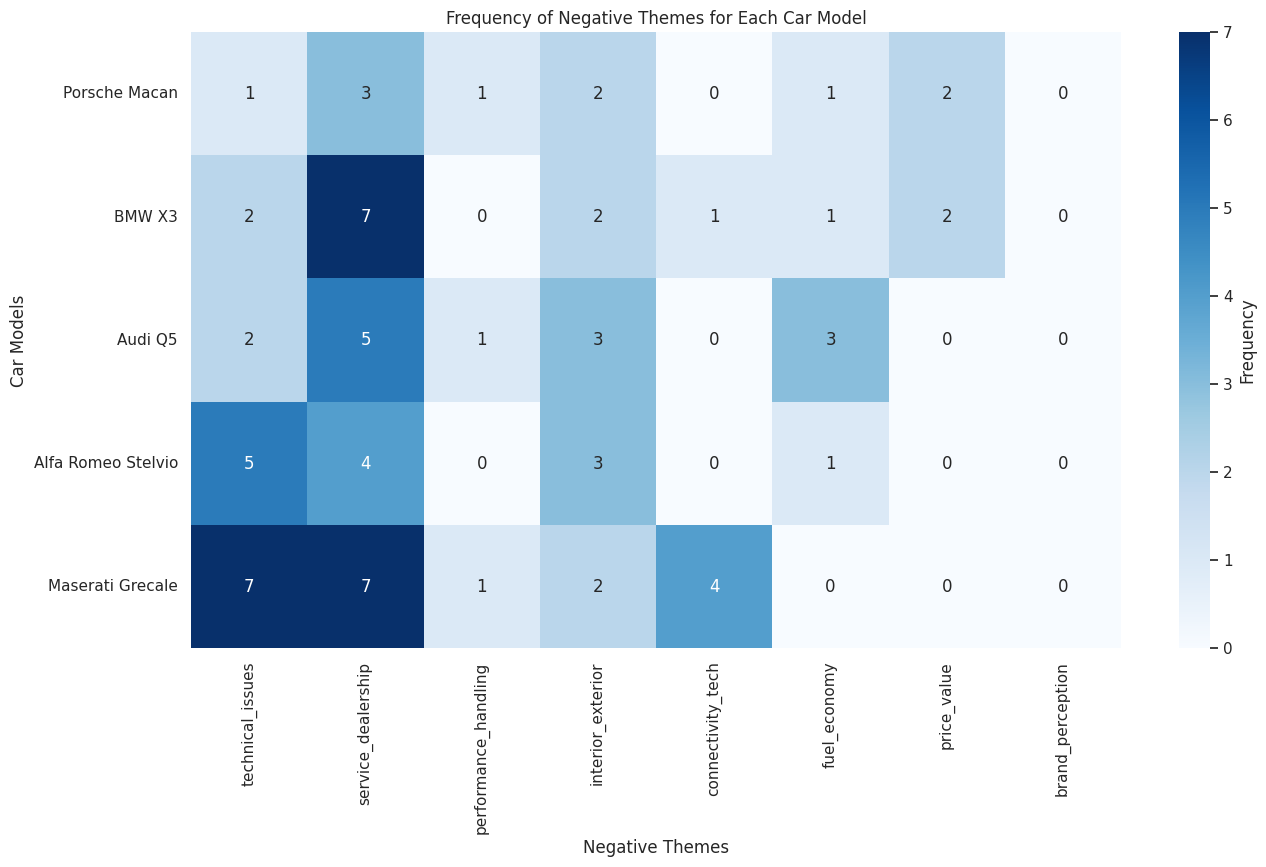

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the broader themes based on the topics' top words
themes = {
    'technical_issues': ['issue', 'battery', 'update', 'work', 'problem', 'light'],
    'service_dealership': ['dealer', 'service', 'warranty', 'order', 'told', 'said'],
    'performance_handling': ['drive', 'engine', 'brake', 'performance', 'handling'],
    'interior_exterior': ['door', 'seat', 'interior', 'exterior', 'wheel', 'tyre', 'look'],
    'connectivity_tech': ['phone', 'charger', 'charging', 'key', 'app'],
    'fuel_economy': ['fuel', 'mile', 'consumption', 'diesel', 'petrol'],
    'price_value': ['price', 'value', 'cost', 'pay', 'msrp'],
    'brand_perception': ['brand', 'reputation', 'name', 'comparison', 'versus']
}

# Define the topics for each model
models_topics = {
    'Porsche Macan': macan_topics,
    'BMW X3': X3_topics,
    'Audi Q5': Q5_topics,
    'Alfa Romeo Stelvio': stelvio_topics,
    'Maserati Grecale': grecale_topics
}

# Count the occurrence of each theme for every model
theme_counts = {theme: [] for theme in themes}

for model, topics in models_topics.items():
    for theme, keywords in themes.items():
        count = sum([word in topic for topic in topics.values() for word in keywords])
        theme_counts[theme].append(count)

# Convert to DataFrame for visualization
df_themes = pd.DataFrame(theme_counts, index=models_topics.keys())

# Plot
plt.figure(figsize=(15, 8))
sns.heatmap(df_themes, annot=True, cmap='Blues', cbar_kws={'label': 'Frequency'})
plt.title('Frequency of Negative Themes for Each Car Model')
plt.xlabel('Negative Themes')
plt.ylabel('Car Models')
plt.show()
